# Air Quality Prediction Model Training
## Delhi AQI Route Optimizer - Machine Learning Component

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')

## 1. Data Collection and Preparation

In [2]:
# Generate synthetic Delhi AQI data for training
# In production, replace this with real WAQI API data

np.random.seed(42)
n_samples = 1000

data = {
    'pm25': np.random.normal(150, 50, n_samples),
    'pm10': np.random.normal(200, 60, n_samples),
    'no2': np.random.normal(80, 30, n_samples),
    'co': np.random.normal(15, 5, n_samples),
    'o3': np.random.normal(60, 20, n_samples),
    'temperature': np.random.normal(28, 8, n_samples),
    'humidity': np.random.normal(60, 15, n_samples),
    'wind_speed': np.random.normal(8, 3, n_samples),
    'hour': np.random.randint(0, 24, n_samples),
    'day_of_week': np.random.randint(0, 7, n_samples),
}

# Calculate overall AQI (target variable)
data['aqi'] = (
    0.35 * data['pm25'] + 
    0.25 * data['pm10'] + 
    0.20 * data['no2'] + 
    0.10 * data['co'] * 10 + 
    0.10 * data['o3'] +
    np.random.normal(0, 10, n_samples)  # Add noise
)

df = pd.DataFrame(data)

# Ensure positive values
df = df.abs()

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (1000, 11)

First few rows:


,pm25,pm10,no2,co,o3,temperature,humidity,wind_speed,hour,day_of_week,aqi
0,174.835708,283.961326,59.744652,5.460962,42.730128,24.609923,43.288780,10.355555,12,1,152.878526
1,143.086785,255.478021,75.664440,10.698075,59.375930,24.372687,50.536037,2.666957,21,6,153.982659
2,182.384427,203.577822,56.227402,12.931972,60.360337,13.634855,45.869097,10.144237,7,6,142.688977
3,226.151493,161.183793,70.761154,24.438438,69.452607,25.359278,51.780063,7.298828,22,6,181.651533
4,138.292331,241.893399,23.191560,17.782766,32.662833,33.862633,56.787745,10.122373,4,1,127.779680


## 2. Exploratory Data Analysis

In [3]:
# Statistical summary
df.describe()

,pm25,pm10,no2,co,o3,temperature,humidity,wind_speed,hour,day_of_week,aqi
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,150.990730,204.250174,80.220516,14.906404,59.028718,27.626099,59.577652,8.078450,11.775000,3.084000,140.707674
std,48.886267,59.847263,29.379594,5.135663,19.805318,8.059114,15.375067,3.071001,6.834404,1.998233,25.668850
min,12.063367,23.576682,0.927568,0.352757,0.152647,4.803889,19.310812,0.044516,0.000000,0.000000,60.537018
25%,117.620485,163.625499,60.560012,11.312898,46.347901,22.450458,48.672940,5.923531,6.000000,1.000000,124.345361
50%,151.265031,203.784628,79.992477,15.000923,59.635160,27.657383,59.178804,8.014939,12.000000,3.000000,140.383351
75%,182.397194,243.732931,99.827459,18.334727,72.782463,32.899575,70.496176,10.170204,18.000000,5.000000,158.010248
max,342.636575,391.586454,197.787131,31.215465,122.258204,52.786395,112.935828,17.353043,23.000000,6.000000,215.083266


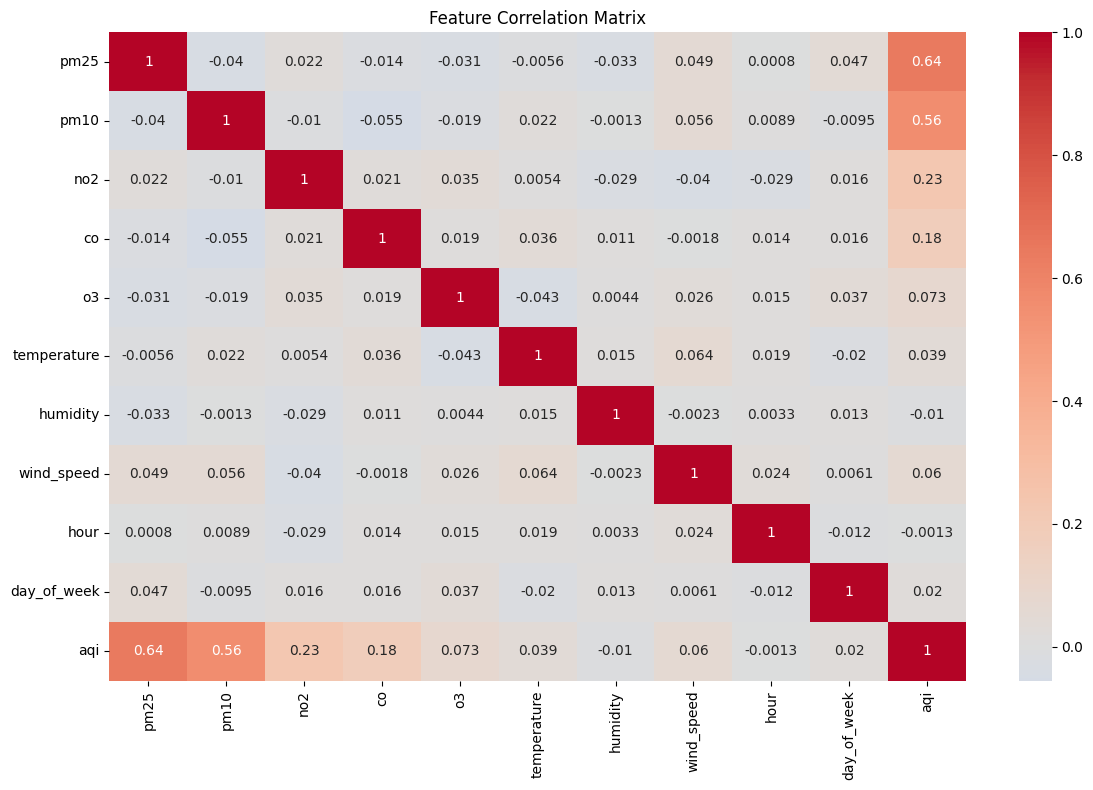

In [4]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

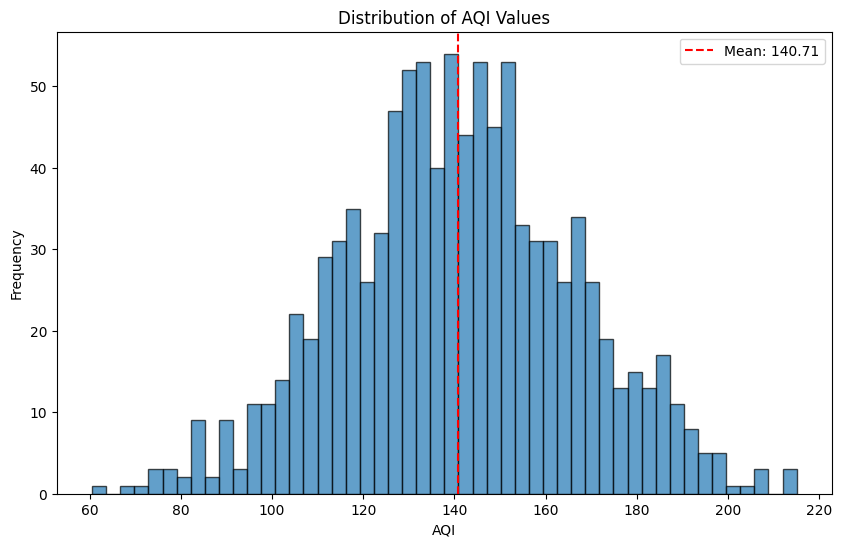

In [5]:
# AQI distribution
plt.figure(figsize=(10, 6))
plt.hist(df['aqi'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.title('Distribution of AQI Values')
plt.axvline(df['aqi'].mean(), color='red', linestyle='--', label=f'Mean: {df["aqi"].mean():.2f}')
plt.legend()
plt.savefig('aqi_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Data Preprocessing

In [6]:
# Separate features and target
X = df.drop('aqi', axis=1)
y = df['aqi']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 800
Test set size: 200


## 4. Model Training and Comparison

In [7]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=100, gamma=0.1)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred_test
    }
    
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"CV R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


Training Linear Regression...
Train RMSE: 9.74
Test RMSE: 8.99
Test R²: 0.8867
Test MAE: 7.15
CV R² Score: 0.8455 (+/- 0.0129)

Training Random Forest...
Train RMSE: 4.37
Test RMSE: 11.42
Test R²: 0.8172
Test MAE: 9.06
CV R² Score: 0.7773 (+/- 0.0210)

Training Gradient Boosting...
Train RMSE: 7.17
Test RMSE: 10.14
Test R²: 0.8559
Test MAE: 8.06
CV R² Score: 0.8012 (+/- 0.0147)

Training Support Vector Regression...
Train RMSE: 5.47
Test RMSE: 11.31
Test R²: 0.8205
Test MAE: 9.16
CV R² Score: 0.7583 (+/- 0.0312)


## 5. Model Comparison Visualization

In [8]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test RMSE': [results[m]['test_rmse'] for m in results],
    'Test R²': [results[m]['test_r2'] for m in results],
    'Test MAE': [results[m]['test_mae'] for m in results],
    'CV R² Mean': [results[m]['cv_mean'] for m in results]
})

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)


MODEL COMPARISON SUMMARY
                    Model  Test RMSE  Test R²  Test MAE  CV R² Mean
        Linear Regression   8.989772 0.886664  7.145744    0.845470
            Random Forest  11.416412 0.817220  9.056770    0.777257
        Gradient Boosting  10.135850 0.855925  8.060797    0.801177
Support Vector Regression  11.312508 0.820532  9.162388    0.758306


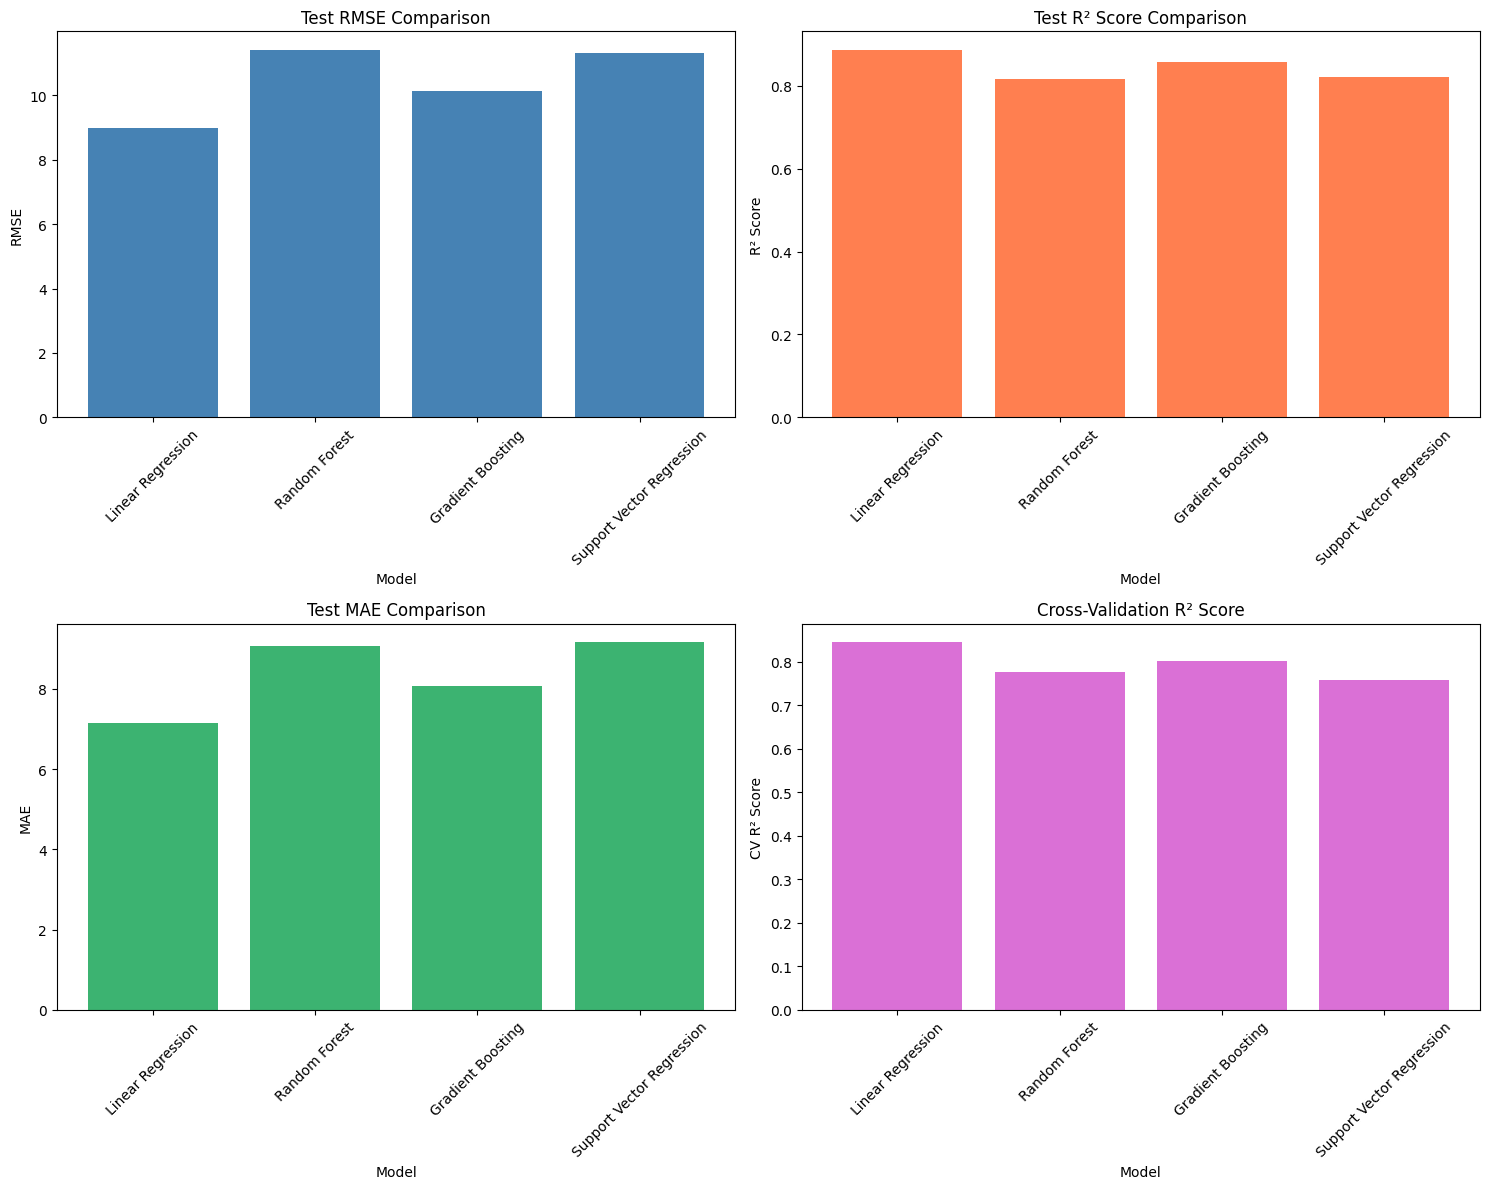

In [9]:
# Visualization: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Test RMSE
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test RMSE'], color='steelblue')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Test RMSE Comparison')
axes[0, 0].tick_params(axis='x', rotation=45)

# Test R²
axes[0, 1].bar(comparison_df['Model'], comparison_df['Test R²'], color='coral')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('Test R² Score Comparison')
axes[0, 1].tick_params(axis='x', rotation=45)

# Test MAE
axes[1, 0].bar(comparison_df['Model'], comparison_df['Test MAE'], color='mediumseagreen')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('Test MAE Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)

# CV R² Mean
axes[1, 1].bar(comparison_df['Model'], comparison_df['CV R² Mean'], color='orchid')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('CV R² Score')
axes[1, 1].set_title('Cross-Validation R² Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

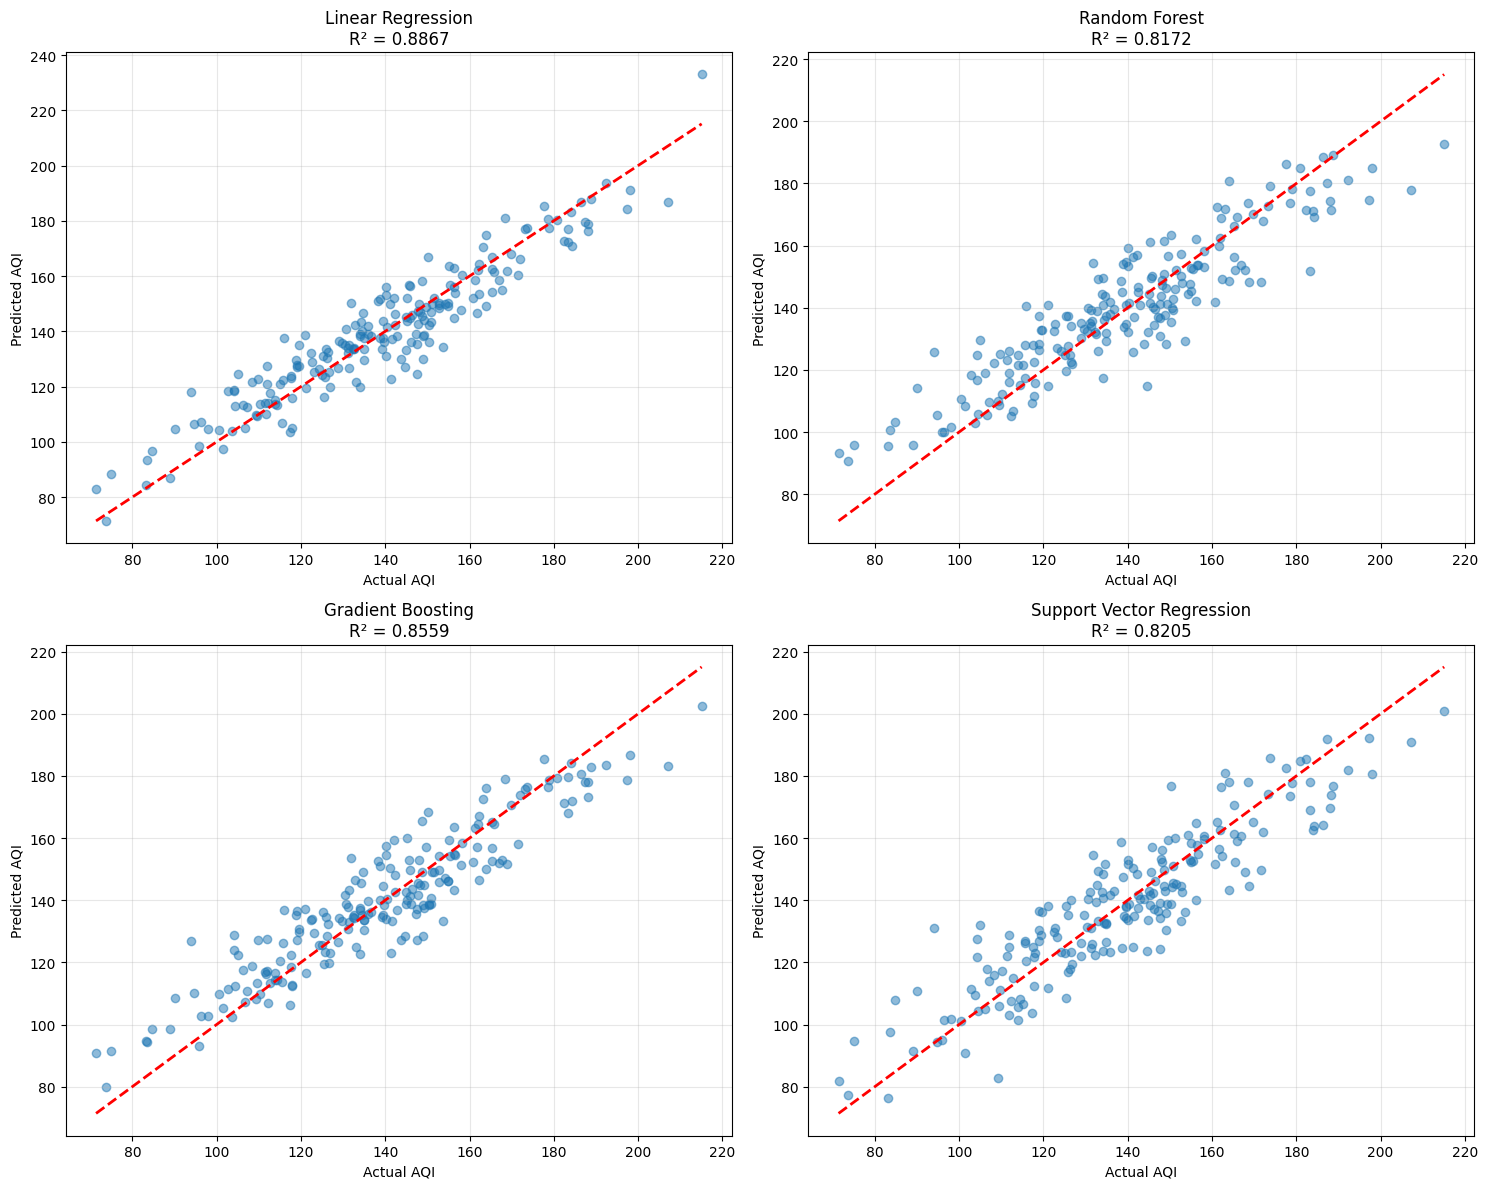

In [10]:
# Prediction vs Actual plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    axes[idx].scatter(y_test, result['predictions'], alpha=0.5)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual AQI')
    axes[idx].set_ylabel('Predicted AQI')
    axes[idx].set_title(f'{name}\nR² = {result["test_r2"]:.4f}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Feature Importance (Random Forest)

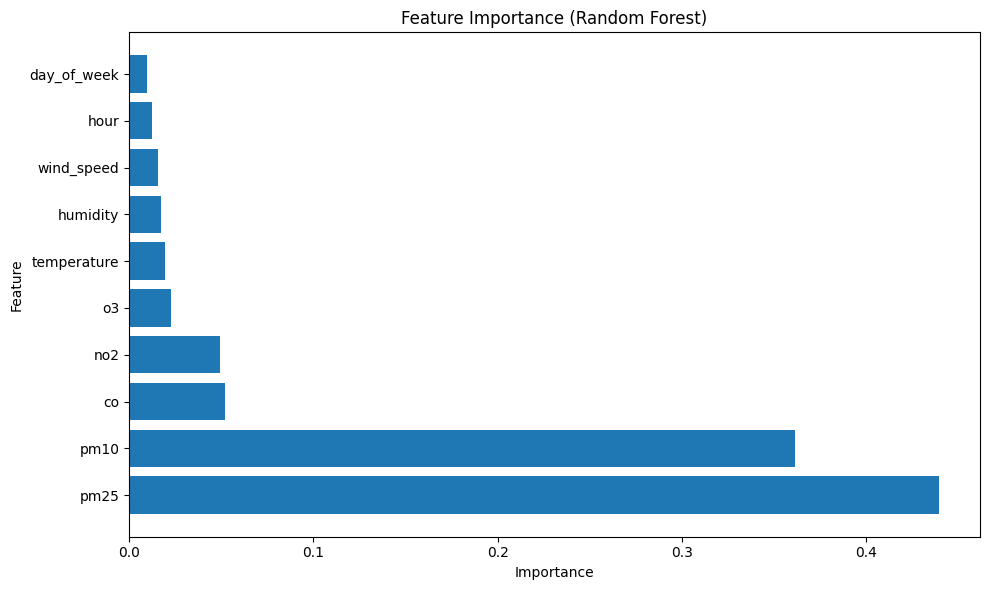


Feature Importance Ranking:
       Feature  Importance
0         pm25    0.439707
1         pm10    0.361293
3           co    0.052155
2          no2    0.049206
4           o3    0.022934
5  temperature    0.019378
6     humidity    0.017589
7   wind_speed    0.015872
8         hour    0.012208
9  day_of_week    0.009658


In [11]:
# Get feature importance from Random Forest
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance)

## 7. Save Best Model

In [12]:
# Find best model based on test R²
best_model_name = max(results, key=lambda x: results[x]['test_r2'])
best_model = results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Test R² Score: {results[best_model_name]['test_r2']:.4f}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.2f}")

# Save model and scaler
with open('aqi_prediction_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nModel and scaler saved successfully!")


Best Model: Linear Regression
Test R² Score: 0.8867
Test RMSE: 8.99

Model and scaler saved successfully!


## 8. Model Testing with Sample Data

In [13]:
# Test with sample pollution data
sample_data = pd.DataFrame({
    'pm25': [200, 100, 50],
    'pm10': [250, 150, 75],
    'no2': [100, 60, 30],
    'co': [20, 10, 5],
    'o3': [80, 50, 25],
    'temperature': [30, 28, 26],
    'humidity': [70, 60, 50],
    'wind_speed': [5, 8, 12],
    'hour': [18, 12, 6],
    'day_of_week': [1, 3, 5]
})

sample_scaled = scaler.transform(sample_data)
predictions = best_model.predict(sample_scaled)

print("\nSample Predictions:")
for i, pred in enumerate(predictions):
    print(f"\nSample {i+1}:")
    print(f"  PM2.5: {sample_data.iloc[i]['pm25']}")
    print(f"  PM10: {sample_data.iloc[i]['pm10']}")
    print(f"  NO2: {sample_data.iloc[i]['no2']}")
    print(f"  Predicted AQI: {pred:.2f}")


Sample Predictions:

Sample 1:
  PM2.5: 200
  PM10: 250
  NO2: 100
  Predicted AQI: 181.51

Sample 2:
  PM2.5: 100
  PM10: 150
  NO2: 60
  Predicted AQI: 99.56

Sample 3:
  PM2.5: 50
  PM10: 75
  NO2: 30
  Predicted AQI: 48.94


## 9. Export Training Summary

In [14]:
# Export comparison results to CSV
comparison_df.to_csv('model_comparison_results.csv', index=False)
print("\nModel comparison results exported to 'model_comparison_results.csv'")

# Export feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print("Feature importance exported to 'feature_importance.csv'")

print("\nTraining complete! All models evaluated and saved.")


Model comparison results exported to 'model_comparison_results.csv'
Feature importance exported to 'feature_importance.csv'

Training complete! All models evaluated and saved.
